# Difference vectors projections onto PCA subspace 
Este código toma una trayectoria completa (previamente fitteada al average) y obtiene los vectores diferencia normalizados. Luego lee los PCA (q también fueron obtenidos en base al average) y proyecta todas los vectores diferencia en la base de los PCA.

In [2]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
set_default_plot_size(32cm, 12cm)

In [3]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [4]:
function read_ptraj_rmsd(file)
    rmsd_file=open(file, "r")
    rmsd_text, rmsd_header = readdlm(rmsd_file, header=true, skipstart=0, skipblanks=true, 
        ignore_invalid_chars=false, comments = false)
    return rmsd_text, rmsd_header
    close(rmsd_file)
end

read_ptraj_rmsd (generic function with 1 method)

In [ ]:
function tognm(in_vtor_anm::Array{Float64, 1})
    aa = Int64
    try
        aa = convert(Int64, length(in_vtor_anm)/3)
    catch InexactError
        throw("Input vector not divisible by 3. Aborting.")
    end
    
    vtor_gnm = Array{Float64}(aa);
    vtor_anm =  in_vtor_anm.^2
    for i=1:aa
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function tognm(in_mtx_anm::Array{Float64, 2})
    aa_vec = Array{Int64, 2}
    nmodes = size(in_mtx_anm)[2]
    try
        aa_vec = mapslices(x->convert(Int64, length(x)/3), in_mtx_anm, 1)
    catch InexactError
        throw("Some input vector not divisible by 3. Aborting.")
    end
    aa = aa_vec[1]
    
    mtx_gnm = Array{Float64}(aa[1], nmodes);
    mtx_anm =  in_mtx_anm.^2
    for j=1:nmodes
        temp = Array{Float64}(aa)
        for i=1:aa
            temp[i] = sqrt(mtx_anm[i*3-2, j] + mtx_anm[i*3-1, j] + mtx_anm[i*3, j])
        end
        mtx_gnm[:, j] = temp
    end
    
    return mtx_gnm
end

## Preparo

In [9]:
home = "/home/german/labo/16/obp/"

"/home/german/labo/16/obp/run/"

## mu_apo

In [13]:
# Preparo variables
mu_apo_tr=Trajectory(string(home, "run/mu_apo/pca/avg_full_fit_mu_apo.nc"))
mu_apo_atom_cnt=convert(Int32, natoms(read_step(mu_apo_tr, 1)))
mu_apo_frames_cnt=convert(Int32, nsteps(mu_apo_tr))
mu_apo_avg_tr=Trajectory(string(home, "run/mu_apo/pca/avg_mu_apo.pdb"));
mu_apo_avg_fr = read(mu_apo_avg_tr);

# Acá leo los indices de los carbonos alfa p/ subsettear los vectores posición.
file_mu_apo_ca_index=openstring(home, "run/mu_apo/ca_index_mu_apo");
mu_apo_ca_index = convert(Array{Int64,2}, readdlm(file_mu_apo_ca_index));
mu_apo_ca_index = reshape(mu_apo_ca_index, length(mu_apo_ca_index))
mu_apo_ca_index3 = map(x -> x*3, 
                    repeat(mu_apo_ca_index, inner=[3])) - repeat([2, 1, 0],
                    outer = [length(mu_apo_ca_index)])
# Subsetteo
mu_apo_avg_xyz = getindex(positions(mu_apo_avg_fr), mu_apo_ca_index3)

# Numero de aa's y de modos
aa = length(mu_apo_ca_index)
aa3 = 3 * aa
aa36 = aa3 - 6
# Preparo más variables
diff_vtr_mu_apo = Array{Float32}(aa3, mu_apo_frames_cnt)
modes_mu_apo = Array{Float32}(aa3, aa36)

# Obtengo los vectores diferencia de los Calpha entre c/ snapshot y el avg
for i=1:mu_apo_frames_cnt
    mu_apo_fr = read_step(mu_apo_tr, i-1)
    mu_apo_xyz = getindex(positions(mu_apo_fr), mu_apo_ca_index3)
    diff_vtr_mu_apo[:, i] = mu_apo_avg_xyz - mu_apo_xyz
    diff_vtr_mu_apo[:, i] = diff_vtr_mu_apo[:, i] / norm(diff_vtr_mu_apo[:, i])
end

# Leo los modos de PCA
modes_mu_apo, evals_mu_apo = read_ptraj_modes(string(home, "run/mu_apo/pca/modes_mu_apo"), aa3);

# Proyecto los vectores diferencia sobre la base de PCA y obtengo los p-numbers
projection_mu_apo = transpose(modes_mu_apo) * diff_vtr_mu_apo;
projection_mu_apo1 = projection_mu_apo.^4;
pnum_mu_apo = mapslices(sum, projection_mu_apo1, 1);
pnum_mu_apo = map(x -> 1/x, pnum_mu_apo);

# Limpio memoria
mu_apo_tr=0;
#modes_mu_apo=0;
#diff_vtr_mu_apo=0;
#projection_mu_apo1=0;
gc();

## mu_ctv

In [14]:
# Preparo variables
mu_ctv_tr=Trajectory(string(home, "run/mu_ctv/pca/avg_full_fit_mu_ctv.nc"))
mu_ctv_atom_cnt=convert(Int32, natoms(read_step(mu_ctv_tr, 1)))
mu_ctv_frames_cnt=convert(Int32, nsteps(mu_ctv_tr))
mu_ctv_avg_tr=Trajectory(string(home, "run/mu_ctv/pca/avg_mu_ctv.pdb"));
mu_ctv_avg_fr = read(mu_ctv_avg_tr);

# Acá leo los indices de los carbonos alfa p/ subsettear los vectores posición.
file_mu_ctv_ca_index=open(string(home, "run/mu_ctv/ca_index_mu_ctv");
mu_ctv_ca_index = convert(Array{Int64,2}, readdlm(file_mu_ctv_ca_index));
mu_ctv_ca_index = reshape(mu_ctv_ca_index, length(mu_ctv_ca_index))
mu_ctv_ca_index3 = map(x -> x*3, 
                    repeat(mu_ctv_ca_index, inner=[3])) - repeat([2, 1, 0],
                    outer = [length(mu_ctv_ca_index)])
# Subsetteo
mu_ctv_avg_xyz = getindex(positions(mu_ctv_avg_fr), mu_ctv_ca_index3)

# Numero de aa's y de modos
aa = length(mu_ctv_ca_index)
aa3 = 3 * aa
aa36 = aa3 - 6
# Preparo más variables
diff_vtr_mu_ctv = Array{Float32}(aa3, mu_ctv_frames_cnt)
modes_mu_ctv = Array{Float32}(aa3, aa36)

# Obtengo los vectores diferencia de los Calpha entre c/ snapshot y el avg
for i=1:mu_ctv_frames_cnt
    mu_ctv_fr = read_step(mu_ctv_tr, i-1)
    mu_ctv_xyz = getindex(positions(mu_ctv_fr), mu_ctv_ca_index3)
    diff_vtr_mu_ctv[:, i] = mu_ctv_avg_xyz - mu_ctv_xyz
    diff_vtr_mu_ctv[:, i] = diff_vtr_mu_ctv[:, i] / norm(diff_vtr_mu_ctv[:, i])
end

# Leo los modos de PCA
modes_mu_ctv, evals_mu_ctv = read_ptraj_modes(string(home, "run/mu_ctv/pca/modes_mu_ctv"), aa3);

# Proyecto los vectores diferencia sobre la base de PCA y obtengo los p-numbers
projection_mu_ctv = transpose(modes_mu_ctv) * diff_vtr_mu_ctv;
projection_mu_ctv1 = projection_mu_ctv.^4;
pnum_mu_ctv = mapslices(sum, projection_mu_ctv1, 1);
pnum_mu_ctv = map(x -> 1/x, pnum_mu_ctv);

# Limpio memoria
mu_ctv_tr=0;
#modes_mu_ctv=0;
#diff_vtr_mu_ctv=0;
#projection_mu_ctv1=0;
gc();


Chemfiles warning: Unknown PDB record: TER    1895      LEU   119 


## mu_eol

In [15]:
# Preparo variables
mu_eol_tr=Trajectory(string(home, "run/mu_eol/pca/avg_full_fit_mu_eol.nc"))
mu_eol_atom_cnt=convert(Int32, natoms(read_step(mu_eol_tr, 1)))
mu_eol_frames_cnt=convert(Int32, nsteps(mu_eol_tr))
mu_eol_avg_tr=Trajectory(string(home, "run/mu_eol/pca/avg_mu_eol.pdb"));
mu_eol_avg_fr = read(mu_eol_avg_tr);

# Acá leo los indices de los carbonos alfa p/ subsettear los vectores posición.
file_mu_eol_ca_index=open(string(home, "run/mu_eol/ca_index_mu_eol");
mu_eol_ca_index = convert(Array{Int64,2}, readdlm(file_mu_eol_ca_index));
mu_eol_ca_index = reshape(mu_ctv_ca_index, length(mu_eol_ca_index))
mu_eol_ca_index3 = map(x -> x*3, 
                    repeat(mu_ctv_ca_index, inner=[3])) - repeat([2, 1, 0],
                    outer = [length(mu_ctv_ca_index)])
# Subsetteo
mu_eol_avg_xyz = getindex(positions(mu_eol_avg_fr), mu_eol_ca_index3)

# Numero de aa's y de modos
aa = length(mu_eol_ca_index)
aa3 = 3 * aa
aa36 = aa3 - 6
# Preparo más variables
diff_vtr_mu_eol = Array{Float32}(aa3, mu_eol_frames_cnt)
modes_mu_eol = Array{Float32}(aa3, aa36)

# Obtengo los vectores diferencia de los Calpha entre c/ snapshot y el avg
for i=1:mu_eol_frames_cnt
    mu_eol_fr = read_step(mu_eol_tr, i-1)
    mu_eol_xyz = getindex(positions(mu_eol_fr), mu_eol_ca_index3)
    diff_vtr_mu_eol[:, i] = mu_eol_avg_xyz - mu_eol_xyz
    diff_vtr_mu_eol[:, i] = diff_vtr_mu_eol[:, i] / norm(diff_vtr_mu_eol[:, i])
end

# Leo los modos de PCA
modes_mu_eol, evals_mu_eol = read_ptraj_modes(string(home, "run/mu_eol/pca/modes_mu_eol"), aa3);

# Proyecto los vectores diferencia sobre la base de PCA y obtengo los p-numbers
projection_mu_eol = transpose(modes_mu_eol) * diff_vtr_mu_eol;
projection_mu_eol1 = projection_mu_eol.^4;
pnum_mu_eol = mapslices(sum, projection_mu_eol1, 1);
pnum_mu_eol = map(x -> 1/x, pnum_mu_eol);

# Limpio memoria
mu_eol_tr=0;
#modes_mu_eol=0;
#diff_vtr_mu_eol=0;
#projection_mu_eol1=0;
gc();

Chemfiles warning: Unknown PDB record: TER    1895      LEU   119 


### Plots

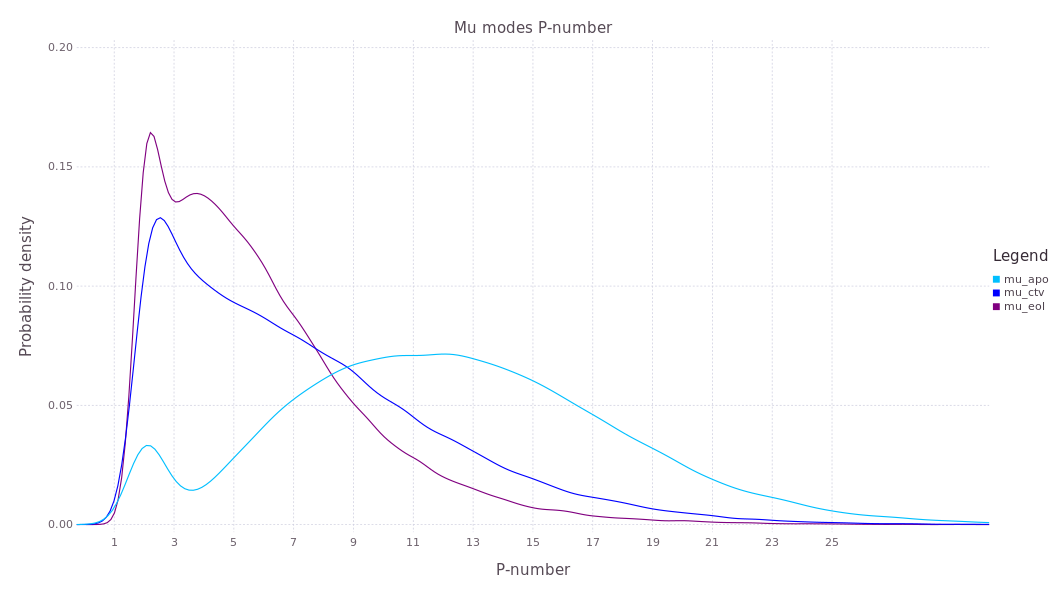

In [16]:
set_default_plot_size(28cm, 16cm)
df_pnum_mu_apo = DataFrame(transpose(pnum_mu_apo));
df_pnum_mu_ctv = DataFrame(transpose(pnum_mu_ctv));
df_pnum_mu_eol = DataFrame(transpose(pnum_mu_eol));

mu_apo_layer = layer(df_pnum_mu_apo, x="x1", Geom.density(), Theme(default_color=colorant"deepskyblue"))
mu_ctv_layer = layer(df_pnum_mu_ctv, x="x1", Geom.density(), Theme(default_color=colorant"blue"))
mu_eol_layer = layer(df_pnum_mu_eol, x="x1", Geom.density(), Theme(default_color=colorant"purple"))

pnum_hist_mu = plot(mu_apo_layer, mu_ctv_layer, mu_eol_layer,
Guide.xlabel("P-number"), Guide.ylabel("Probability density"), Guide.Title("Mu modes P-number"),
Guide.manual_color_key("Legend", ["mu_apo", "mu_ctv", "mu_eol"],
["deepskyblue", "blue", "purple"]),
Coord.Cartesian(xmin=0, xmax=30),
Guide.xticks(ticks = collect(1:2:25), orientation=:horizontal))

## Ahora obtengo los espacios esenciales a c/ frame, y en éstos me obtengo la frecuencia de aparición de c/ modo.

In [11]:
# Redondeo los pnumbers
df_pnum_mu_apo[:x1] = round(df_pnum_mu_apo[:x1]);
df_pnum_mu_ctv[:x1] = round(df_pnum_mu_ctv[:x1]);
df_pnum_mu_eol[:x1] = round(df_pnum_mu_eol[:x1]);

# Obtengo los valores absolutos de las proyecciones
projection_mu_apo1 = abs(projection_mu_apo);
projection_mu_ctv1 = abs(projection_mu_ctv);
projection_mu_eol1 = abs(projection_mu_eol);

# A c/ frame, ordeno los modos según su proyección con el vector diferencia correspondiente
index_mu_apo = mapslices(x->sortperm(x, rev = true), projection_mu_apo1, 1)
index_mu_ctv = mapslices(x->sortperm(x, rev = true), projection_mu_ctv1, 1)
index_mu_eol = mapslices(x->sortperm(x, rev = true), projection_mu_eol1, 1);

### Obtengo los índices de los pnum modos p/ c/ snapshot

In [13]:
# mu_apo
pmodes_index_mu_apo=Array{Int64}(1);
for i=1:mu_apo_frames_cnt-1
    pnum = convert(Int, df_pnum_mu_apo[i, 1])
    append!(pmodes_index_mu_apo, index_mu_apo[1:pnum, i])
end
shift!(pmodes_index_mu_apo);

# mu_ctv
pmodes_index_mu_ctv=Array{Int64}(1);
for i=1:mu_ctv_frames_cnt-1
    pnum = convert(Int, df_pnum_mu_ctv[i, 1])
    append!(pmodes_index_mu_ctv, index_mu_ctv[1:pnum, i])
end
shift!(pmodes_index_mu_ctv);

# mu_eol
pmodes_index_mu_eol=Array{Int64}(1);
for i=1:mu_eol_frames_cnt-1
    pnum = convert(Int, df_pnum_mu_eol[i, 1])
    append!(pmodes_index_mu_eol, index_mu_eol[1:pnum, i])
end
shift!(pmodes_index_mu_eol);

### Plots

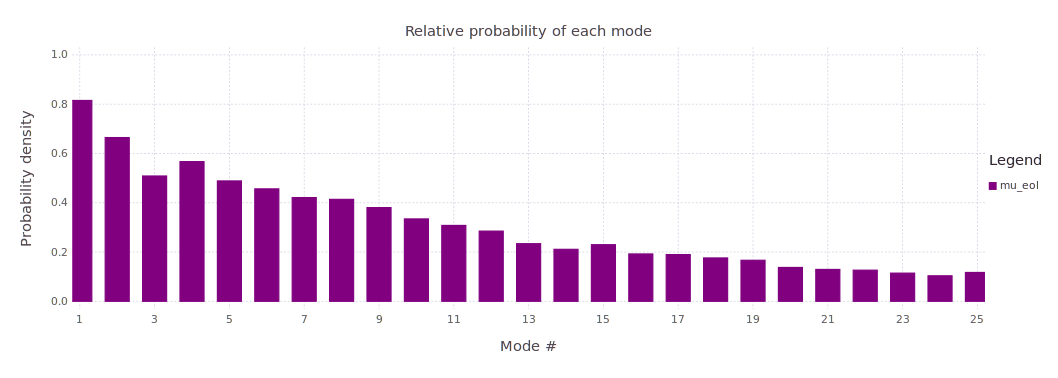

In [14]:
set_default_plot_size(28cm, 10cm)

# mu_apo
bins_mu_apo, counts_mu_apo = hist(pmodes_index_mu_apo, collect(0:aa36-1))
xmin_mu_apo = bins_mu_apo
xmax_mu_apo = bins_mu_apo .+ 0.33
pop!(xmin_mu_apo)
pop!(xmax_mu_apo)
freq_mu_apo = counts_mu_apo / mu_apo_frames_cnt
pmodes_index_mu_apo_layer = layer(xmin = xmin_mu_apo, xmax = xmax_mu_apo, y = freq_mu_apo, Geom.bar(position=:dodge),
Theme(default_color=colorant"deepskyblue", bar_spacing = 10pt));

# mu_ctv
bins_mu_ctv, counts_mu_ctv = hist(pmodes_index_mu_ctv, collect(0:aa36-1))
xmin_mu_ctv = bins_mu_ctv .+ 0.33
xmax_mu_ctv = bins_mu_ctv .+ 0.66
pop!(xmin_mu_ctv)
pop!(xmax_mu_ctv)
freq_mu_ctv = counts_mu_ctv / mu_ctv_frames_cnt
pmodes_index_mu_ctv_layer = layer(xmin = xmin_mu_ctv, xmax= xmax_mu_ctv, y = freq_mu_ctv, Geom.bar(position=:dodge),
Theme(default_color=colorant"blue", bar_spacing = 10pt))

# mu_eol
bins_mu_eol, counts_mu_eol = hist(pmodes_index_mu_eol, collect(0:aa36-1))
xmin_mu_eol = bins_mu_eol .+ 0.66
xmax_mu_eol = bins_mu_eol .+ 1.0
pop!(xmin_mu_eol)
pop!(xmax_mu_eol)
freq_mu_eol = counts_mu_eol / mu_eol_frames_cnt
pmodes_index_mu_eol_layer = layer(xmin = xmin_mu_eol, xmax= xmax_mu_eol, y = freq_mu_eol, Geom.bar(position=:dodge),
Theme(default_color=colorant"purple", line_width = 1pt, bar_highlight = colorant"purple", bar_spacing = 10pt))

pmodes_hist_mu_apo = plot(pmodes_index_mu_apo_layer,
Guide.xlabel("Mode #"), Guide.ylabel("Probability density"), Guide.Title("Relative probability of each mode"),
Guide.manual_color_key("Legend", ["mu_apo"],
["deepskyblue"]),
Coord.Cartesian(xmin=1, xmax=25),
Guide.xticks(ticks = collect(1:2:25), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.2:1.0), orientation=:horizontal));

pmodes_hist_mu_ctv = plot(pmodes_index_mu_ctv_layer,
Guide.xlabel("Mode #"), Guide.ylabel("Probability density"), Guide.Title("Relative probability of each mode"),
Guide.manual_color_key("Legend", ["mu_ctv"],
["blue"]),
Coord.Cartesian(xmin=1, xmax=25),
Guide.xticks(ticks = collect(1:2:25), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.2:1.0), orientation=:horizontal));

pmodes_hist_mu_eol = plot(pmodes_index_mu_eol_layer,
Guide.xlabel("Mode #"), Guide.ylabel("Probability density"), Guide.Title("Relative probability of each mode"),
Guide.manual_color_key("Legend", ["mu_eol"],
["purple"]),
Coord.Cartesian(xmin=1, xmax=25),
Guide.xticks(ticks = collect(1:2:25), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.2:1.0), orientation=:horizontal));

pmodes_hist_mu_apo
pmodes_hist_mu_ctv
pmodes_hist_mu_eol

In [15]:
draw(PDF("pmodes_hist_mu.pdf", 20cm, 40cm), vstack(pmodes_hist_mu_apo, pmodes_hist_mu_ctv, pmodes_hist_mu_eol));

# P number de c/ modo según SSE

In [16]:
# Defino los Calphas de las structs secundarias
α1=collect(1:19)
    l1=collect(20:22)
α2=collect(23:30)
    l2=collect(31:38)
α3=collect(39:51)
    l3=collect(52:62)
α4=collect(63:70)
    l4=collect(71:75)
α5=collect(76:86)
    l5=collect(87:93)
α6=collect(94:106)
    l6=collect(107:110)
α7=collect(111:114)

# Ahora los indices de sus coordenadas xyz
α13 = map(x -> x*3, repeat(α1, inner=[3])) - repeat([2, 1, 0], outer = [length(α1)])
α23 = map(x -> x*3, repeat(α2, inner=[3])) - repeat([2, 1, 0], outer = [length(α2)])
α33 = map(x -> x*3, repeat(α3, inner=[3])) - repeat([2, 1, 0], outer = [length(α3)])
α43 = map(x -> x*3, repeat(α4, inner=[3])) - repeat([2, 1, 0], outer = [length(α4)])
α53 = map(x -> x*3, repeat(α5, inner=[3])) - repeat([2, 1, 0], outer = [length(α5)])
α63 = map(x -> x*3, repeat(α6, inner=[3])) - repeat([2, 1, 0], outer = [length(α6)])
α73 = map(x -> x*3, repeat(α7, inner=[3])) - repeat([2, 1, 0], outer = [length(α7)]);

l13 = map(x -> x*3, repeat(l1, inner=[3])) - repeat([2, 1, 0], outer = [length(l1)])
l23 = map(x -> x*3, repeat(l2, inner=[3])) - repeat([2, 1, 0], outer = [length(l2)])
l33 = map(x -> x*3, repeat(l3, inner=[3])) - repeat([2, 1, 0], outer = [length(l3)])
l43 = map(x -> x*3, repeat(l4, inner=[3])) - repeat([2, 1, 0], outer = [length(l4)])
l53 = map(x -> x*3, repeat(l5, inner=[3])) - repeat([2, 1, 0], outer = [length(l5)])
l63 = map(x -> x*3, repeat(l6, inner=[3])) - repeat([2, 1, 0], outer = [length(l6)]);

## mu_apo

In [17]:
# Leo los modos de PCA
modes_mu_apo, evals_mu_apo = read_ptraj_modes("/home/german/labo/16/obp/run/mu_apo/modes_mu_apo", aa3);
# Defino subespacio esencial
essential_index_mu_apo = sort(unique(pmodes_index_mu_apo)); # 116 modos
essential_aa36_mu_apo = size(essential_index_mu_apo)[1]
essential_subsp_mu_apo = modes_mu_apo[: , essential_index_mu_apo]







# Subsetteo el essential subspace segun SSE
essential_subsp_α1_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[α13, :], 1)
essential_subsp_α2_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[α23, :], 1)
essential_subsp_α3_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[α33, :], 1)
essential_subsp_α4_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[α43, :], 1)
essential_subsp_α5_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[α53, :], 1)
essential_subsp_α6_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[α63, :], 1)
essential_subsp_α7_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[α73, :], 1)

essential_subsp_l1_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[l13, :], 1)
essential_subsp_l2_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[l23, :], 1)
essential_subsp_l3_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[l33, :], 1)
essential_subsp_l4_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[l43, :], 1)
essential_subsp_l5_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[l53, :], 1)
essential_subsp_l6_mu_apo = mapslices(x -> x/norm(x), essential_subsp_mu_apo[l63, :], 1)
# version sin normalizar
essential_subsp_α1_mu_apo = essential_subsp_mu_apo[α13, :]
essential_subsp_α2_mu_apo = essential_subsp_mu_apo[α23, :]
essential_subsp_α3_mu_apo = essential_subsp_mu_apo[α33, :]
essential_subsp_α4_mu_apo = essential_subsp_mu_apo[α43, :]
essential_subsp_α5_mu_apo = essential_subsp_mu_apo[α53, :]
essential_subsp_α6_mu_apo = essential_subsp_mu_apo[α63, :]
essential_subsp_α7_mu_apo = essential_subsp_mu_apo[α73, :]

essential_subsp_l1_mu_apo = essential_subsp_mu_apo[l13, :]
essential_subsp_l2_mu_apo = essential_subsp_mu_apo[l23, :]
essential_subsp_l3_mu_apo = essential_subsp_mu_apo[l33, :]
essential_subsp_l4_mu_apo = essential_subsp_mu_apo[l43, :]
essential_subsp_l5_mu_apo = essential_subsp_mu_apo[l53, :]
essential_subsp_l6_mu_apo = essential_subsp_mu_apo[l63, :]



# 1era parte p/ obtener el pnumber de c/ modo
α1_mtx_mu_apo = sum((essential_subsp_α1_mu_apo.^2), 1).^2
α2_mtx_mu_apo = sum((essential_subsp_α2_mu_apo.^2), 1).^2
α3_mtx_mu_apo = sum((essential_subsp_α3_mu_apo.^2), 1).^2
α4_mtx_mu_apo = sum((essential_subsp_α4_mu_apo.^2), 1).^2
α5_mtx_mu_apo = sum((essential_subsp_α5_mu_apo.^2), 1).^2
α6_mtx_mu_apo = sum((essential_subsp_α6_mu_apo.^2), 1).^2
α7_mtx_mu_apo = sum((essential_subsp_α7_mu_apo.^2), 1).^2

l1_mtx_mu_apo = sum((essential_subsp_l1_mu_apo.^2), 1).^2
l2_mtx_mu_apo = sum((essential_subsp_l2_mu_apo.^2), 1).^2
l3_mtx_mu_apo = sum((essential_subsp_l3_mu_apo.^2), 1).^2
l4_mtx_mu_apo = sum((essential_subsp_l4_mu_apo.^2), 1).^2
l5_mtx_mu_apo = sum((essential_subsp_l5_mu_apo.^2), 1).^2
l6_mtx_mu_apo = sum((essential_subsp_l6_mu_apo.^2), 1).^2

# Preparo variables
sse_mu_apo = Array{Float64}[α1_mtx_mu_apo, α2_mtx_mu_apo, α3_mtx_mu_apo, α4_mtx_mu_apo, α5_mtx_mu_apo,
    α6_mtx_mu_apo, α7_mtx_mu_apo, l1_mtx_mu_apo, l2_mtx_mu_apo, l3_mtx_mu_apo,
    l4_mtx_mu_apo, l5_mtx_mu_apo, l6_mtx_mu_apo]
pnum_sse_mu_apo = Array{Float64}(essential_aa36_mu_apo)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_apo
    j=1
    temp = 0
    for sse in sse_mu_apo
        temp = temp + sse[i]  
    end
    pnum_sse_mu_apo[i] = 1 / temp
end

## mu_ctv

In [18]:
# Leo los modos de PCA
modes_mu_ctv, evals_mu_ctv = read_ptraj_modes("/home/german/labo/16/obp/run/mu_ctv/modes_mu_ctv", aa3);
# Defino subespacio esencial
essential_index_mu_ctv = sort(unique(pmodes_index_mu_ctv)); # 116 modos
essential_aa36_mu_ctv = size(essential_index_mu_ctv)[1]
essential_subsp_mu_ctv = modes_mu_ctv[: , essential_index_mu_ctv]





# Subsetteo el essential subspace segun SSE
essential_subsp_α1_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[α13, :], 1)
essential_subsp_α2_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[α23, :], 1)
essential_subsp_α3_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[α33, :], 1)
essential_subsp_α4_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[α43, :], 1)
essential_subsp_α5_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[α53, :], 1)
essential_subsp_α6_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[α63, :], 1)
essential_subsp_α7_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[α73, :], 1)

essential_subsp_l1_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[l13, :], 1)
essential_subsp_l2_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[l23, :], 1)
essential_subsp_l3_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[l33, :], 1)
essential_subsp_l4_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[l43, :], 1)
essential_subsp_l5_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[l53, :], 1)
essential_subsp_l6_mu_ctv = mapslices(x -> x/norm(x), essential_subsp_mu_ctv[l63, :], 1)
# version sin normalizar
essential_subsp_α1_mu_ctv = essential_subsp_mu_ctv[α13, :]
essential_subsp_α2_mu_ctv = essential_subsp_mu_ctv[α23, :]
essential_subsp_α3_mu_ctv = essential_subsp_mu_ctv[α33, :]
essential_subsp_α4_mu_ctv = essential_subsp_mu_ctv[α43, :]
essential_subsp_α5_mu_ctv = essential_subsp_mu_ctv[α53, :]
essential_subsp_α6_mu_ctv = essential_subsp_mu_ctv[α63, :]
essential_subsp_α7_mu_ctv = essential_subsp_mu_ctv[α73, :]

essential_subsp_l1_mu_ctv = essential_subsp_mu_ctv[l13, :]
essential_subsp_l2_mu_ctv = essential_subsp_mu_ctv[l23, :]
essential_subsp_l3_mu_ctv = essential_subsp_mu_ctv[l33, :]
essential_subsp_l4_mu_ctv = essential_subsp_mu_ctv[l43, :]
essential_subsp_l5_mu_ctv = essential_subsp_mu_ctv[l53, :]
essential_subsp_l6_mu_ctv = essential_subsp_mu_ctv[l63, :]





# 1era parte p/ obtener el pnumber de c/ modo
α1_mtx_mu_ctv = sum((essential_subsp_α1_mu_ctv.^2), 1).^2
α2_mtx_mu_ctv = sum((essential_subsp_α2_mu_ctv.^2), 1).^2
α3_mtx_mu_ctv = sum((essential_subsp_α3_mu_ctv.^2), 1).^2
α4_mtx_mu_ctv = sum((essential_subsp_α4_mu_ctv.^2), 1).^2
α5_mtx_mu_ctv = sum((essential_subsp_α5_mu_ctv.^2), 1).^2
α6_mtx_mu_ctv = sum((essential_subsp_α6_mu_ctv.^2), 1).^2
α7_mtx_mu_ctv = sum((essential_subsp_α7_mu_ctv.^2), 1).^2

l1_mtx_mu_ctv = sum((essential_subsp_l1_mu_ctv.^2), 1).^2
l2_mtx_mu_ctv = sum((essential_subsp_l2_mu_ctv.^2), 1).^2
l3_mtx_mu_ctv = sum((essential_subsp_l3_mu_ctv.^2), 1).^2
l4_mtx_mu_ctv = sum((essential_subsp_l4_mu_ctv.^2), 1).^2
l5_mtx_mu_ctv = sum((essential_subsp_l5_mu_ctv.^2), 1).^2
l6_mtx_mu_ctv = sum((essential_subsp_l6_mu_ctv.^2), 1).^2

# Preparo variables
sse_mu_ctv = Array{Float64}[α1_mtx_mu_ctv, α2_mtx_mu_ctv, α3_mtx_mu_ctv, α4_mtx_mu_ctv, α5_mtx_mu_ctv,
    α6_mtx_mu_ctv, α7_mtx_mu_ctv, l1_mtx_mu_ctv, l2_mtx_mu_ctv, l3_mtx_mu_ctv,
    l4_mtx_mu_ctv, l5_mtx_mu_ctv, l6_mtx_mu_ctv]
pnum_sse_mu_ctv = Array{Float64}(essential_aa36_mu_ctv)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_ctv
    j=1
    temp = 0
    for sse in sse_mu_ctv
        temp = temp + sse[i]  
    end
    pnum_sse_mu_ctv[i] = 1 / temp
end

## mu_eol

In [19]:
# Leo los modos de PCA
modes_mu_eol, evals_mu_eol = read_ptraj_modes("/home/german/labo/16/obp/run/mu_eol/modes_mu_eol", aa3);
# Defino subespacio esencial
essential_index_mu_eol = sort(unique(pmodes_index_mu_eol)); # 116 modos
essential_aa36_mu_eol = size(essential_index_mu_eol)[1]
essential_subsp_mu_eol = modes_mu_eol[: , essential_index_mu_eol]







# Subsetteo el essential subspace segun SSE
essential_subsp_α1_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[α13, :], 1)
essential_subsp_α2_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[α23, :], 1)
essential_subsp_α3_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[α33, :], 1)
essential_subsp_α4_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[α43, :], 1)
essential_subsp_α5_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[α53, :], 1)
essential_subsp_α6_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[α63, :], 1)
essential_subsp_α7_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[α73, :], 1)

essential_subsp_l1_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[l13, :], 1)
essential_subsp_l2_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[l23, :], 1)
essential_subsp_l3_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[l33, :], 1)
essential_subsp_l4_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[l43, :], 1)
essential_subsp_l5_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[l53, :], 1)
essential_subsp_l6_mu_eol = mapslices(x -> x/norm(x), essential_subsp_mu_eol[l63, :], 1)
# version sin normalizar
essential_subsp_α1_mu_eol = essential_subsp_mu_eol[α13, :]
essential_subsp_α2_mu_eol = essential_subsp_mu_eol[α23, :]
essential_subsp_α3_mu_eol = essential_subsp_mu_eol[α33, :]
essential_subsp_α4_mu_eol = essential_subsp_mu_eol[α43, :]
essential_subsp_α5_mu_eol = essential_subsp_mu_eol[α53, :]
essential_subsp_α6_mu_eol = essential_subsp_mu_eol[α63, :]
essential_subsp_α7_mu_eol = essential_subsp_mu_eol[α73, :]

essential_subsp_l1_mu_eol = essential_subsp_mu_eol[l13, :]
essential_subsp_l2_mu_eol = essential_subsp_mu_eol[l23, :]
essential_subsp_l3_mu_eol = essential_subsp_mu_eol[l33, :]
essential_subsp_l4_mu_eol = essential_subsp_mu_eol[l43, :]
essential_subsp_l5_mu_eol = essential_subsp_mu_eol[l53, :]
essential_subsp_l6_mu_eol = essential_subsp_mu_eol[l63, :]




# 1era parte p/ obtener el pnumber de c/ modo
α1_mtx_mu_eol = sum((essential_subsp_α1_mu_eol.^2), 1).^2
α2_mtx_mu_eol = sum((essential_subsp_α2_mu_eol.^2), 1).^2
α3_mtx_mu_eol = sum((essential_subsp_α3_mu_eol.^2), 1).^2
α4_mtx_mu_eol = sum((essential_subsp_α4_mu_eol.^2), 1).^2
α5_mtx_mu_eol = sum((essential_subsp_α5_mu_eol.^2), 1).^2
α6_mtx_mu_eol = sum((essential_subsp_α6_mu_eol.^2), 1).^2
α7_mtx_mu_eol = sum((essential_subsp_α7_mu_eol.^2), 1).^2

l1_mtx_mu_eol = sum((essential_subsp_l1_mu_eol.^2), 1).^2
l2_mtx_mu_eol = sum((essential_subsp_l2_mu_eol.^2), 1).^2
l3_mtx_mu_eol = sum((essential_subsp_l3_mu_eol.^2), 1).^2
l4_mtx_mu_eol = sum((essential_subsp_l4_mu_eol.^2), 1).^2
l5_mtx_mu_eol = sum((essential_subsp_l5_mu_eol.^2), 1).^2
l6_mtx_mu_eol = sum((essential_subsp_l6_mu_eol.^2), 1).^2

# Preparo variables
sse_mu_eol = Array{Float64}[α1_mtx_mu_eol, α2_mtx_mu_eol, α3_mtx_mu_eol, α4_mtx_mu_eol, α5_mtx_mu_eol,
    α6_mtx_mu_eol, α7_mtx_mu_eol, l1_mtx_mu_eol, l2_mtx_mu_eol, l3_mtx_mu_eol,
    l4_mtx_mu_eol, l5_mtx_mu_eol, l6_mtx_mu_eol]
pnum_sse_mu_eol = Array{Float64}(essential_aa36_mu_eol)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_eol
    j=1
    temp = 0
    for sse in sse_mu_eol
        temp = temp + sse[i]  
    end
    pnum_sse_mu_eol[i] = 1 / temp
end

### Plot!

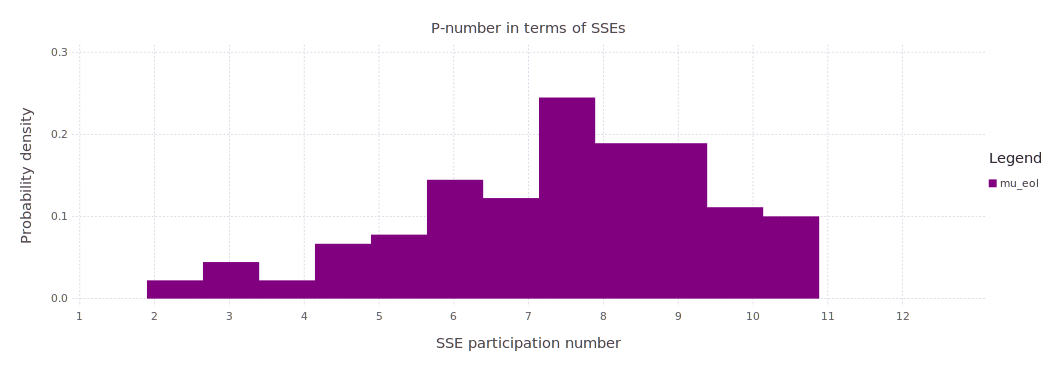

In [20]:
df_pnum_sse_mu_apo = DataFrame(transpose(transpose(pnum_sse_mu_apo)));
df_pnum_sse_mu_ctv = DataFrame(transpose(transpose(pnum_sse_mu_ctv)));
df_pnum_sse_mu_eol = DataFrame(transpose(transpose(pnum_sse_mu_eol)));

pnum_sse_mu_apo_layer = layer(df_pnum_sse_mu_apo, x = "x1", Geom.histogram(density = true, bincount = 12),
Theme(default_color=colorant"deepskyblue"));
pnum_sse_mu_ctv_layer = layer(df_pnum_sse_mu_ctv, x = "x1", Geom.histogram(density = true, bincount = 12),
Theme(default_color=colorant"blue"));
pnum_sse_mu_eol_layer = layer(df_pnum_sse_mu_eol, x = "x1", Geom.histogram(density = true, bincount = 12),
Theme(default_color=colorant"purple"));


pnum_sse_mu_apo_hist = plot(pnum_sse_mu_apo_layer,
Guide.xlabel("SSE participation number"), Guide.ylabel("Probability density"), 
Guide.Title("P-number in terms of SSEs"),
Guide.manual_color_key("Legend", ["mu_apo"], ["deepskyblue"]),
Coord.Cartesian(xmin=1, xmax=13),
Guide.xticks(ticks = collect(1:1:12), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.1:0.3), orientation=:horizontal));

pnum_sse_mu_ctv_hist = plot(pnum_sse_mu_ctv_layer,
Guide.xlabel("SSE participation number"), Guide.ylabel("Probability density"), 
Guide.Title("P-number in terms of SSEs"),
Guide.manual_color_key("Legend", ["mu_ctv"], ["blue"]),
Coord.Cartesian(xmin=1, xmax=13),
Guide.xticks(ticks = collect(1:1:12), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.1:0.3), orientation=:horizontal));

pnum_sse_mu_eol_hist = plot(pnum_sse_mu_eol_layer,
Guide.xlabel("SSE participation number"), Guide.ylabel("Probability density"), 
Guide.Title("P-number in terms of SSEs"),
Guide.manual_color_key("Legend", ["mu_eol"], ["purple"]),
Coord.Cartesian(xmin=1, xmax=13),
Guide.xticks(ticks = collect(1:1:12), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.1:.3), orientation=:horizontal));

#pnum_sse_mu_apo_hist
#pnum_sse_mu_ctv_hist
#pnum_sse_mu_eol_hist

In [21]:
draw(PDF("sse_hist_mu.pdf", 45cm, 15cm), hstack(pnum_sse_mu_apo_hist, pnum_sse_mu_ctv_hist, pnum_sse_mu_eol_hist));

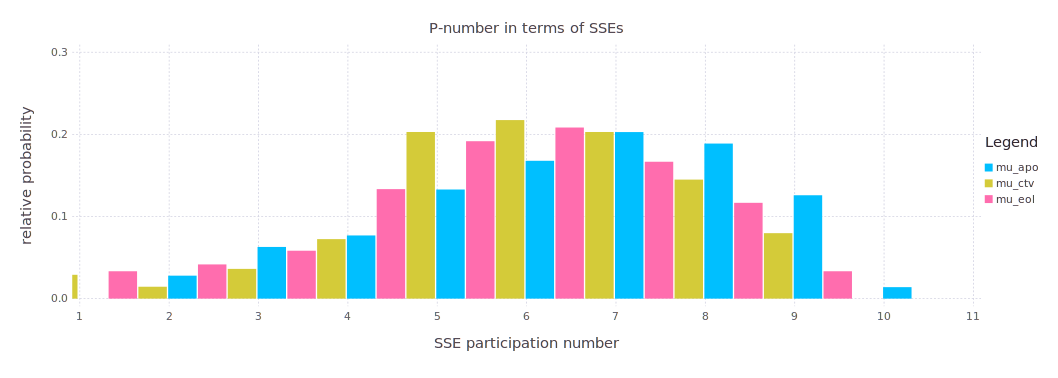

In [22]:
# otro plotteo

# Hago los histogramas
pnum_sse_mu_apo = convert(Array{Int64}, round(pnum_sse_mu_apo))
sse_xmax_mu_apo, sse_freq_mu_apo = hist(pnum_sse_mu_apo, collect(1:1:13))
sse_freq_mu_apo = sse_freq_mu_apo / essential_aa36_mu_apo
sse_xmin_mu_apo = sse_xmax_mu_apo .- .33
pop!(sse_xmin_mu_apo)
pop!(sse_xmax_mu_apo)

pnum_sse_mu_ctv = convert(Array{Int64}, round(pnum_sse_mu_ctv))
sse_xmax_mu_ctv, sse_freq_mu_ctv = hist(pnum_sse_mu_ctv, collect(1:1:13))
sse_freq_mu_ctv = sse_freq_mu_ctv / essential_aa36_mu_ctv
sse_xmin_mu_ctv = sse_xmax_mu_ctv .- .66
pop!(sse_xmin_mu_ctv)
pop!(sse_xmax_mu_ctv)

pnum_sse_mu_eol = convert(Array{Int64}, round(pnum_sse_mu_eol))
sse_xmax_mu_eol, sse_freq_mu_eol = hist(pnum_sse_mu_eol, collect(1:1:13))
sse_freq_mu_eol = sse_freq_mu_eol / essential_aa36_mu_eol
sse_xmin_mu_eol = sse_xmax_mu_eol .- 1
pop!(sse_xmin_mu_eol)
pop!(sse_xmax_mu_eol)



# Los junto en un dataframe
names = [repeat(["mu_apo"], inner=[12]); repeat(["mu_ctv"], inner=[12]); repeat(["mu_eol"], inner=[12])]
datos = [sse_freq_mu_apo; sse_freq_mu_ctv; sse_freq_mu_eol ]
xmins = [sse_xmin_mu_apo; sse_xmin_mu_ctv; sse_xmin_mu_eol]
xmaxs = [sse_xmax_mu_apo; sse_xmax_mu_ctv; sse_xmax_mu_eol]
df_datos = DataFrame(Legend=names, RelativeProbability=datos, xmin=xmins, xmax=xmaxs-.2) # acomodo el xmaxs

pnum_sse_hist = plot(df_datos, x="xmax", y="RelativeProbability", color="Legend", 
Geom.bar(position=:dodge),
Scale.x_continuous,
Theme(bar_spacing=3pt, default_color=colorant"black"),
Guide.Title("P-number in terms of SSEs"),
Coord.Cartesian(xmin=1, xmax=11),
Guide.xticks(ticks = collect(1:1:11), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.1:0.3), orientation=:horizontal), 
Guide.xlabel("SSE participation number"), Guide.ylabel("relative probability"))

In [23]:
draw(PDF("sse_hist_mu2.pdf", 45cm, 15cm), pnum_sse_hist);

# Ahora hago SSE pero hélices y loops por separado

In [24]:
# Primero tengo q obtener nuevos indices p/ las hélices y los loops
# hélices
hα13 = collect(1: length(α13))
hα23 = collect(hα13[end]+1: hα13[end]+length(α23))
hα33 = collect(hα23[end]+1: hα23[end]+length(α33))
hα43 = collect(hα33[end]+1: hα33[end]+length(α43))
hα53 = collect(hα43[end]+1: hα43[end]+length(α53))
hα63 = collect(hα53[end]+1: hα53[end]+length(α63))
hα73 = collect(hα63[end]+1: hα63[end]+length(α73));

## helices

## mu_apo

In [25]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
αnorm_essential_subsp_mu_apo = [essential_subsp_α1_mu_apo; essential_subsp_α2_mu_apo; essential_subsp_α3_mu_apo; 
    essential_subsp_α4_mu_apo; essential_subsp_α5_mu_apo; essential_subsp_α6_mu_apo; essential_subsp_α7_mu_apo];
# lo renormalizo
αnorm_essential_subsp_mu_apo = mapslices(x -> x/norm(x), αnorm_essential_subsp_mu_apo, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_α1_mu_apo = αnorm_essential_subsp_mu_apo[hα13, :]
essential_subsp_α2_mu_apo = αnorm_essential_subsp_mu_apo[hα23, :]
essential_subsp_α3_mu_apo = αnorm_essential_subsp_mu_apo[hα33, :]
essential_subsp_α4_mu_apo = αnorm_essential_subsp_mu_apo[hα43, :]
essential_subsp_α5_mu_apo = αnorm_essential_subsp_mu_apo[hα53, :]
essential_subsp_α6_mu_apo = αnorm_essential_subsp_mu_apo[hα63, :]
essential_subsp_α7_mu_apo = αnorm_essential_subsp_mu_apo[hα73, :]

# 1era parte p/ obtener el pnumber
α1_mtx_mu_apo = sum((essential_subsp_α1_mu_apo.^2), 1).^2
α2_mtx_mu_apo = sum((essential_subsp_α2_mu_apo.^2), 1).^2
α3_mtx_mu_apo = sum((essential_subsp_α3_mu_apo.^2), 1).^2
α4_mtx_mu_apo = sum((essential_subsp_α4_mu_apo.^2), 1).^2
α5_mtx_mu_apo = sum((essential_subsp_α5_mu_apo.^2), 1).^2
α6_mtx_mu_apo = sum((essential_subsp_α6_mu_apo.^2), 1).^2
α7_mtx_mu_apo = sum((essential_subsp_α7_mu_apo.^2), 1).^2

# junto todo en una lista
sse_mu_apo = Array{Float64}[α1_mtx_mu_apo, α2_mtx_mu_apo, α3_mtx_mu_apo, α4_mtx_mu_apo, α5_mtx_mu_apo,
    α6_mtx_mu_apo, α7_mtx_mu_apo]
# Preparo variable
pnum_sse_mu_apo = Array{Float64}(essential_aa36_mu_apo)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_apo
    j=1
    temp = 0
    for sse in sse_mu_apo
        temp = temp + sse[i]  
    end
    pnum_sse_mu_apo[i] = 1 / temp
end

## mu_ctv

In [26]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
αnorm_essential_subsp_mu_ctv = [essential_subsp_α1_mu_ctv; essential_subsp_α2_mu_ctv; essential_subsp_α3_mu_ctv;
    essential_subsp_α4_mu_ctv; essential_subsp_α5_mu_ctv; essential_subsp_α6_mu_ctv; essential_subsp_α7_mu_ctv];
# lo renormalizo
αnorm_essential_subsp_mu_ctv = mapslices(x -> x/norm(x), αnorm_essential_subsp_mu_ctv, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_α1_mu_ctv = αnorm_essential_subsp_mu_ctv[hα13, :]
essential_subsp_α2_mu_ctv = αnorm_essential_subsp_mu_ctv[hα23, :]
essential_subsp_α3_mu_ctv = αnorm_essential_subsp_mu_ctv[hα33, :]
essential_subsp_α4_mu_ctv = αnorm_essential_subsp_mu_ctv[hα43, :]
essential_subsp_α5_mu_ctv = αnorm_essential_subsp_mu_ctv[hα53, :]
essential_subsp_α6_mu_ctv = αnorm_essential_subsp_mu_ctv[hα63, :]
essential_subsp_α7_mu_ctv = αnorm_essential_subsp_mu_ctv[hα73, :]

# 1era parte p/ obtener el pnumber
α1_mtx_mu_ctv = sum((essential_subsp_α1_mu_ctv.^2), 1).^2
α2_mtx_mu_ctv = sum((essential_subsp_α2_mu_ctv.^2), 1).^2
α3_mtx_mu_ctv = sum((essential_subsp_α3_mu_ctv.^2), 1).^2
α4_mtx_mu_ctv = sum((essential_subsp_α4_mu_ctv.^2), 1).^2
α5_mtx_mu_ctv = sum((essential_subsp_α5_mu_ctv.^2), 1).^2
α6_mtx_mu_ctv = sum((essential_subsp_α6_mu_ctv.^2), 1).^2
α7_mtx_mu_ctv = sum((essential_subsp_α7_mu_ctv.^2), 1).^2

# junto todo en una lista
sse_mu_ctv = Array{Float64}[α1_mtx_mu_ctv, α2_mtx_mu_ctv, α3_mtx_mu_ctv, α4_mtx_mu_ctv, α5_mtx_mu_ctv,
    α6_mtx_mu_ctv, α7_mtx_mu_ctv]
pnum_sse_mu_ctv = Array{Float64}(essential_aa36_mu_ctv)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_ctv
    j=1
    temp = 0
    for sse in sse_mu_ctv
        temp = temp + sse[i]  
    end
    pnum_sse_mu_ctv[i] = 1 / temp
end



## mu_eol

In [27]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
αnorm_essential_subsp_mu_eol = [essential_subsp_α1_mu_eol; essential_subsp_α2_mu_eol; essential_subsp_α3_mu_eol;
    essential_subsp_α4_mu_eol; essential_subsp_α5_mu_eol; essential_subsp_α6_mu_eol; essential_subsp_α7_mu_eol];
# lo renormalizo
αnorm_essential_subsp_mu_eol = mapslices(x -> x/norm(x), αnorm_essential_subsp_mu_eol, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_α1_mu_eol = αnorm_essential_subsp_mu_eol[hα13, :]
essential_subsp_α2_mu_eol = αnorm_essential_subsp_mu_eol[hα23, :]
essential_subsp_α3_mu_eol = αnorm_essential_subsp_mu_eol[hα33, :]
essential_subsp_α4_mu_eol = αnorm_essential_subsp_mu_eol[hα43, :]
essential_subsp_α5_mu_eol = αnorm_essential_subsp_mu_eol[hα53, :]
essential_subsp_α6_mu_eol = αnorm_essential_subsp_mu_eol[hα63, :]
essential_subsp_α7_mu_eol = αnorm_essential_subsp_mu_eol[hα73, :]

# 1era parte p/ obtener el pnumber
α1_mtx_mu_eol = sum((essential_subsp_α1_mu_eol.^2), 1).^2
α2_mtx_mu_eol = sum((essential_subsp_α2_mu_eol.^2), 1).^2
α3_mtx_mu_eol = sum((essential_subsp_α3_mu_eol.^2), 1).^2
α4_mtx_mu_eol = sum((essential_subsp_α4_mu_eol.^2), 1).^2
α5_mtx_mu_eol = sum((essential_subsp_α5_mu_eol.^2), 1).^2
α6_mtx_mu_eol = sum((essential_subsp_α6_mu_eol.^2), 1).^2
α7_mtx_mu_eol = sum((essential_subsp_α7_mu_eol.^2), 1).^2

# junto todo en una lista
sse_mu_eol = Array{Float64}[α1_mtx_mu_eol, α2_mtx_mu_eol, α3_mtx_mu_eol, α4_mtx_mu_eol, α5_mtx_mu_eol,
    α6_mtx_mu_eol, α7_mtx_mu_eol]
# Preparo variable
pnum_sse_mu_eol = Array{Float64}(essential_aa36_mu_eol)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_eol
    j=1
    temp = 0
    for sse in sse_mu_eol
        temp = temp + sse[i]  
    end
    pnum_sse_mu_eol[i] = 1 / temp
end

## Plot de helices

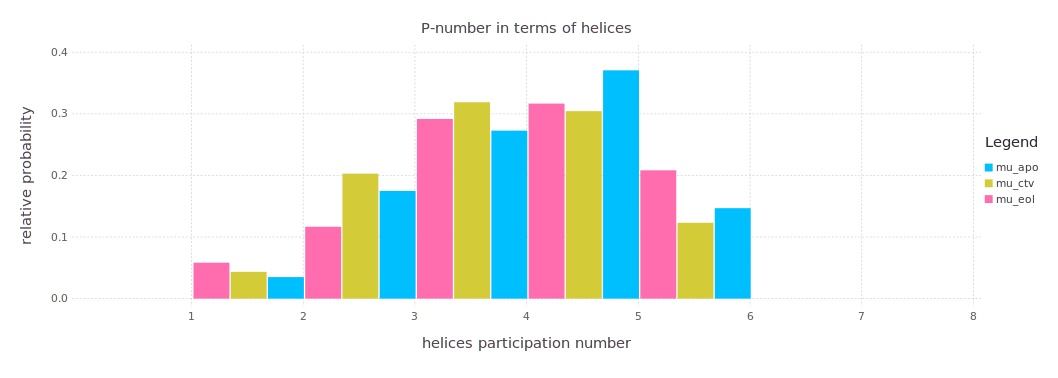

In [28]:
# otro plotteo

# Hago los histogramas
pnum_sse_mu_apo = convert(Array{Int64}, round(pnum_sse_mu_apo))
sse_xmax_mu_apo, sse_freq_mu_apo = hist(pnum_sse_mu_apo, collect(1:1:8))
sse_freq_mu_apo = sse_freq_mu_apo / essential_aa36_mu_apo
sse_xmin_mu_apo = sse_xmax_mu_apo .- .33
pop!(sse_xmin_mu_apo)
pop!(sse_xmax_mu_apo)

pnum_sse_mu_ctv = convert(Array{Int64}, round(pnum_sse_mu_ctv))
sse_xmax_mu_ctv, sse_freq_mu_ctv = hist(pnum_sse_mu_ctv, collect(1:1:8))
sse_freq_mu_ctv = sse_freq_mu_ctv / essential_aa36_mu_ctv
sse_xmin_mu_ctv = sse_xmax_mu_ctv .- .66
pop!(sse_xmin_mu_ctv)
pop!(sse_xmax_mu_ctv)

pnum_sse_mu_eol = convert(Array{Int64}, round(pnum_sse_mu_eol))
sse_xmax_mu_eol, sse_freq_mu_eol = hist(pnum_sse_mu_eol, collect(1:1:8))
sse_freq_mu_eol = sse_freq_mu_eol / essential_aa36_mu_eol
sse_xmin_mu_eol = sse_xmax_mu_eol .- 1
pop!(sse_xmin_mu_eol)
pop!(sse_xmax_mu_eol)


# Los junto en un dataframe
names = [repeat(["mu_apo"], inner=[7]); repeat(["mu_ctv"], inner=[7]); repeat(["mu_eol"], inner=[7])]
datos = [sse_freq_mu_apo; sse_freq_mu_ctv; sse_freq_mu_eol ]
xmins = [sse_xmin_mu_apo; sse_xmin_mu_ctv; sse_xmin_mu_eol]
xmaxs = [sse_xmax_mu_apo; sse_xmax_mu_ctv; sse_xmax_mu_eol]
df_datos_helices = DataFrame(Legend=names, RelativeProbability=datos, xmin=xmins, xmax=xmaxs+.5) # acomodo el xmaxs

pnum_helices_hist = plot(df_datos_helices, x="xmax", y="RelativeProbability", color="Legend", 
Geom.bar(position=:dodge),
Scale.x_continuous,
Theme(bar_spacing=3pt, default_color=colorant"black"),
Guide.Title("P-number in terms of helices"),
Coord.Cartesian(xmin=0, xmax=8),
Guide.xticks(ticks = collect(1:1:8), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.1:0.4), orientation=:horizontal), 
Guide.xlabel("helices participation number"), Guide.ylabel("relative probability"))

##  loops

In [29]:
# loops
ll13 = collect(1: length(l13))
ll23 = collect(ll13[end]+1: ll13[end]+length(l23))
ll33 = collect(ll23[end]+1: ll23[end]+length(l33))
ll43 = collect(ll33[end]+1: ll33[end]+length(l43))
ll53 = collect(ll43[end]+1: ll43[end]+length(l53))
ll63 = collect(ll53[end]+1: ll53[end]+length(l63));

## mu_apo

In [30]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
lnorm_essential_subsp_mu_apo = [essential_subsp_l1_mu_apo; essential_subsp_l2_mu_apo; essential_subsp_l3_mu_apo;
    essential_subsp_l4_mu_apo; essential_subsp_l5_mu_apo; essential_subsp_l6_mu_apo];
# lo renormalizo
lnorm_essential_subsp_mu_apo = mapslices(x -> x/norm(x), lnorm_essential_subsp_mu_apo, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_l1_mu_apo = lnorm_essential_subsp_mu_apo[ll13, :]
essential_subsp_l2_mu_apo = lnorm_essential_subsp_mu_apo[ll23, :]
essential_subsp_l3_mu_apo = lnorm_essential_subsp_mu_apo[ll33, :]
essential_subsp_l4_mu_apo = lnorm_essential_subsp_mu_apo[ll43, :]
essential_subsp_l5_mu_apo = lnorm_essential_subsp_mu_apo[ll53, :]
essential_subsp_l6_mu_apo = lnorm_essential_subsp_mu_apo[ll63, :]

# 1era parte p/ obtener el pnumber
l1_mtx_mu_apo = sum((essential_subsp_l1_mu_apo.^2), 1).^2
l2_mtx_mu_apo = sum((essential_subsp_l2_mu_apo.^2), 1).^2
l3_mtx_mu_apo = sum((essential_subsp_l3_mu_apo.^2), 1).^2
l4_mtx_mu_apo = sum((essential_subsp_l4_mu_apo.^2), 1).^2
l5_mtx_mu_apo = sum((essential_subsp_l5_mu_apo.^2), 1).^2
l6_mtx_mu_apo = sum((essential_subsp_l6_mu_apo.^2), 1).^2

# junto todo en una lista
sse_mu_apo = Array{Float64}[l1_mtx_mu_apo, l2_mtx_mu_apo, l3_mtx_mu_apo, l4_mtx_mu_apo, l5_mtx_mu_apo,
    l6_mtx_mu_apo]
# Preparo variable
pnum_sse_mu_apo = Array{Float64}(essential_aa36_mu_apo)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_apo
    j=1
    temp = 0
    for sse in sse_mu_apo
        temp = temp + sse[i]
    end
    pnum_sse_mu_apo[i] = 1 / temp
end

## mu_ctv

In [31]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
lnorm_essential_subsp_mu_ctv = [essential_subsp_l1_mu_ctv; essential_subsp_l2_mu_ctv; essential_subsp_l3_mu_ctv;
    essential_subsp_l4_mu_ctv; essential_subsp_l5_mu_ctv; essential_subsp_l6_mu_ctv];
# lo renormalizo
lnorm_essential_subsp_mu_ctv = mapslices(x -> x/norm(x), lnorm_essential_subsp_mu_ctv, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_l1_mu_ctv = lnorm_essential_subsp_mu_ctv[ll13, :]
essential_subsp_l2_mu_ctv = lnorm_essential_subsp_mu_ctv[ll23, :]
essential_subsp_l3_mu_ctv = lnorm_essential_subsp_mu_ctv[ll33, :]
essential_subsp_l4_mu_ctv = lnorm_essential_subsp_mu_ctv[ll43, :]
essential_subsp_l5_mu_ctv = lnorm_essential_subsp_mu_ctv[ll53, :]
essential_subsp_l6_mu_ctv = lnorm_essential_subsp_mu_ctv[ll63, :]

# 1era parte p/ obtener el pnumber
l1_mtx_mu_ctv = sum((essential_subsp_l1_mu_ctv.^2), 1).^2
l2_mtx_mu_ctv = sum((essential_subsp_l2_mu_ctv.^2), 1).^2
l3_mtx_mu_ctv = sum((essential_subsp_l3_mu_ctv.^2), 1).^2
l4_mtx_mu_ctv = sum((essential_subsp_l4_mu_ctv.^2), 1).^2
l5_mtx_mu_ctv = sum((essential_subsp_l5_mu_ctv.^2), 1).^2
l6_mtx_mu_ctv = sum((essential_subsp_l6_mu_ctv.^2), 1).^2

# junto todo en una lista
sse_mu_ctv = Array{Float64}[l1_mtx_mu_ctv, l2_mtx_mu_ctv, l3_mtx_mu_ctv, l4_mtx_mu_ctv, l5_mtx_mu_ctv,
    l6_mtx_mu_ctv]
# Preparo variable
pnum_sse_mu_ctv = Array{Float64}(essential_aa36_mu_ctv)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_ctv
    j=1
    temp = 0
    for sse in sse_mu_ctv
        temp = temp + sse[i]
    end
    pnum_sse_mu_ctv[i] = 1 / temp
end

## mu_eol

In [32]:
# Preparo variables
# subsetteo el subespacio esencial q corresponde a las hélices
lnorm_essential_subsp_mu_eol = [essential_subsp_l1_mu_eol; essential_subsp_l2_mu_eol; essential_subsp_l3_mu_eol;
    essential_subsp_l4_mu_eol; essential_subsp_l5_mu_eol; essential_subsp_l6_mu_eol];
# lo renormalizo
lnorm_essential_subsp_mu_eol = mapslices(x -> x/norm(x), lnorm_essential_subsp_mu_eol, 1)
# y ahora si, separo los subespacios de c/ hélice
essential_subsp_l1_mu_eol = lnorm_essential_subsp_mu_eol[ll13, :]
essential_subsp_l2_mu_eol = lnorm_essential_subsp_mu_eol[ll23, :]
essential_subsp_l3_mu_eol = lnorm_essential_subsp_mu_eol[ll33, :]
essential_subsp_l4_mu_eol = lnorm_essential_subsp_mu_eol[ll43, :]
essential_subsp_l5_mu_eol = lnorm_essential_subsp_mu_eol[ll53, :]
essential_subsp_l6_mu_eol = lnorm_essential_subsp_mu_eol[ll63, :]

# 1era parte p/ obtener el pnumber
l1_mtx_mu_eol = sum((essential_subsp_l1_mu_eol.^2), 1).^2
l2_mtx_mu_eol = sum((essential_subsp_l2_mu_eol.^2), 1).^2
l3_mtx_mu_eol = sum((essential_subsp_l3_mu_eol.^2), 1).^2
l4_mtx_mu_eol = sum((essential_subsp_l4_mu_eol.^2), 1).^2
l5_mtx_mu_eol = sum((essential_subsp_l5_mu_eol.^2), 1).^2
l6_mtx_mu_eol = sum((essential_subsp_l6_mu_eol.^2), 1).^2

# junto todo en una lista
sse_mu_eol = Array{Float64}[l1_mtx_mu_eol, l2_mtx_mu_eol, l3_mtx_mu_eol, l4_mtx_mu_eol, l5_mtx_mu_eol,
    l6_mtx_mu_eol]
# Preparo variable
pnum_sse_mu_eol = Array{Float64}(essential_aa36_mu_eol)

# Saco los números de SSE q mueve c/ modo
for i = 1:essential_aa36_mu_eol
    j=1
    temp = 0
    for sse in sse_mu_eol
        temp = temp + sse[i]
    end
    pnum_sse_mu_eol[i] = 1 / temp
end


## Plot de loops

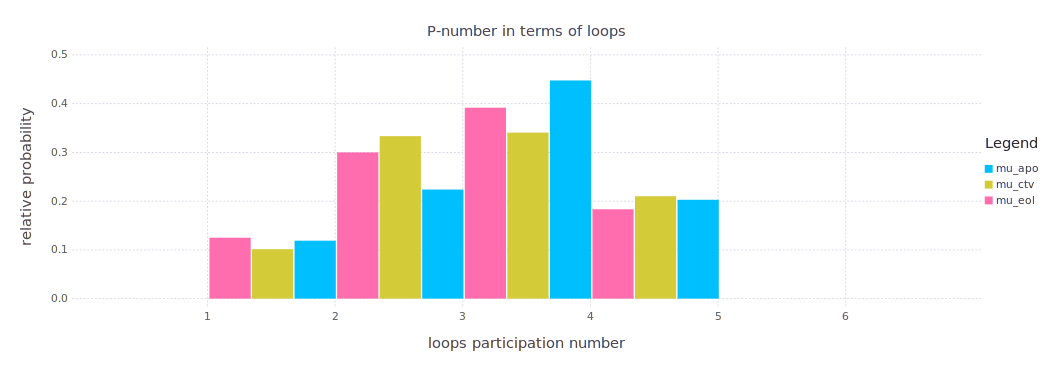

In [33]:
# otro plotteo

# Hago los histogramas
pnum_sse_mu_apo = convert(Array{Int64}, round(pnum_sse_mu_apo))
sse_xmax_mu_apo, sse_freq_mu_apo = hist(pnum_sse_mu_apo, collect(1:1:7))
sse_freq_mu_apo = sse_freq_mu_apo / essential_aa36_mu_apo
sse_xmin_mu_apo = sse_xmax_mu_apo .- .33
pop!(sse_xmin_mu_apo)
pop!(sse_xmax_mu_apo)

pnum_sse_mu_ctv = convert(Array{Int64}, round(pnum_sse_mu_ctv))
sse_xmax_mu_ctv, sse_freq_mu_ctv = hist(pnum_sse_mu_ctv, collect(1:1:7))
sse_freq_mu_ctv = sse_freq_mu_ctv / essential_aa36_mu_ctv
sse_xmin_mu_ctv = sse_xmax_mu_ctv .- .66
pop!(sse_xmin_mu_ctv)
pop!(sse_xmax_mu_ctv)

pnum_sse_mu_eol = convert(Array{Int64}, round(pnum_sse_mu_eol))
sse_xmax_mu_eol, sse_freq_mu_eol = hist(pnum_sse_mu_eol, collect(1:1:7))
sse_freq_mu_eol = sse_freq_mu_eol / essential_aa36_mu_eol
sse_xmin_mu_eol = sse_xmax_mu_eol .- 1
pop!(sse_xmin_mu_eol)
pop!(sse_xmax_mu_eol)


# Los junto en un dataframe
names = [repeat(["mu_apo"], inner=[6]); repeat(["mu_ctv"], inner=[6]); repeat(["mu_eol"], inner=[6])]
datos = [sse_freq_mu_apo; sse_freq_mu_ctv; sse_freq_mu_eol ]
xmins = [sse_xmin_mu_apo; sse_xmin_mu_ctv; sse_xmin_mu_eol]
xmaxs = [sse_xmax_mu_apo; sse_xmax_mu_ctv; sse_xmax_mu_eol]
df_datos_loops = DataFrame(Legend=names, RelativeProbability=datos, xmin=xmins, xmax=xmaxs+.5) # acomodo el xmaxs

#pnum_loops_hist = plot(df_datos_loops, xmin="xmin", xmax="xmax", y="RelativeProbability", color="Legend",
pnum_loops_hist = plot(df_datos_loops, x="xmax", y="RelativeProbability", color="Legend",
Geom.bar(position=:dodge),
Scale.x_continuous,
Theme(bar_spacing=3pt, default_color=colorant"black"),
Guide.Title("P-number in terms of loops"),
Coord.Cartesian(xmin=0, xmax=7),
Guide.xticks(ticks = collect(1:1:6), orientation=:horizontal),
Guide.yticks(ticks = collect(0.0:0.1:0.5), orientation=:horizontal), 
Guide.xlabel("loops participation number"), Guide.ylabel("relative probability"))

In [34]:
draw(PDF("loops-vs-helices_hist_mu2.pdf", 45cm, 15cm), hstack(pnum_helices_hist, pnum_loops_hist));

## RMSD de SSEs

## mu_apo

In [35]:
# Leo los rmsds
rmsd_a1_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a1_rmsd_mu_apo")
        rmsd_l1_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/l1_rmsd_mu_apo")
rmsd_a2_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a2_rmsd_mu_apo")
        rmsd_l2_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a2_rmsd_mu_apo")
rmsd_a3_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a3_rmsd_mu_apo")
        rmsd_l3_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a3_rmsd_mu_apo")
rmsd_a4_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a4_rmsd_mu_apo")
        rmsd_l4_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a4_rmsd_mu_apo")
rmsd_a5_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a5_rmsd_mu_apo")
        rmsd_l5_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a5_rmsd_mu_apo")
rmsd_a6_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a6_rmsd_mu_apo")
        rmsd_l6_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a6_rmsd_mu_apo")
rmsd_a7_mu_apo, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_apo/rmsd/a7_rmsd_mu_apo");

# Los compilo en un array
rmsd_mu_apo = [mean(rmsd_a1_mu_apo[:, 2]); mean(rmsd_a2_mu_apo[:, 2]); mean(rmsd_a3_mu_apo[:, 2]); mean(rmsd_a4_mu_apo[:, 2]);
mean(rmsd_a5_mu_apo[:, 2]); mean(rmsd_a6_mu_apo[:, 2]); mean(rmsd_a7_mu_apo[:, 2]); mean(rmsd_l1_mu_apo[:, 2]);
mean(rmsd_l2_mu_apo[:, 2]); mean(rmsd_l3_mu_apo[:, 2]); mean(rmsd_l4_mu_apo[:, 2]); mean(rmsd_l5_mu_apo[:, 2]);
mean(rmsd_l6_mu_apo[:, 2])];

## mu_ctv

In [36]:
# Leo los rmsds
rmsd_a1_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a1_rmsd_mu_ctv")
        rmsd_l1_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/l1_rmsd_mu_ctv")
rmsd_a2_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a2_rmsd_mu_ctv")
        rmsd_l2_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a2_rmsd_mu_ctv")
rmsd_a3_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a3_rmsd_mu_ctv")
        rmsd_l3_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a3_rmsd_mu_ctv")
rmsd_a4_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a4_rmsd_mu_ctv")
        rmsd_l4_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a4_rmsd_mu_ctv")
rmsd_a5_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a5_rmsd_mu_ctv")
        rmsd_l5_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a5_rmsd_mu_ctv")
rmsd_a6_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a6_rmsd_mu_ctv")
        rmsd_l6_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a6_rmsd_mu_ctv")
rmsd_a7_mu_ctv, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_ctv/rmsd/a7_rmsd_mu_ctv");

# Los compilo en un array
rmsd_mu_ctv = [mean(rmsd_a1_mu_ctv[:, 2]); mean(rmsd_a2_mu_ctv[:, 2]); mean(rmsd_a3_mu_ctv[:, 2]); mean(rmsd_a4_mu_ctv[:, 2]);
mean(rmsd_a5_mu_ctv[:, 2]); mean(rmsd_a6_mu_ctv[:, 2]); mean(rmsd_a7_mu_ctv[:, 2]); mean(rmsd_l1_mu_ctv[:, 2]);
mean(rmsd_l2_mu_ctv[:, 2]); mean(rmsd_l3_mu_ctv[:, 2]); mean(rmsd_l4_mu_ctv[:, 2]); mean(rmsd_l5_mu_ctv[:, 2]);
mean(rmsd_l6_mu_ctv[:, 2])];

## mu_eol

In [37]:
# Leo los rmsds
rmsd_a1_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a1_rmsd_mu_eol")
        rmsd_l1_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/l1_rmsd_mu_eol")
rmsd_a2_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a2_rmsd_mu_eol")
        rmsd_l2_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a2_rmsd_mu_eol")
rmsd_a3_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a3_rmsd_mu_eol")
        rmsd_l3_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a3_rmsd_mu_eol")
rmsd_a4_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a4_rmsd_mu_eol")
        rmsd_l4_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a4_rmsd_mu_eol")
rmsd_a5_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a5_rmsd_mu_eol")
        rmsd_l5_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a5_rmsd_mu_eol")
rmsd_a6_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a6_rmsd_mu_eol")
        rmsd_l6_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a6_rmsd_mu_eol")
rmsd_a7_mu_eol, header = read_ptraj_rmsd("/home/german/labo/16/obp/run/mu_eol/rmsd/a7_rmsd_mu_eol");

# Los compilo en un array
rmsd_mu_eol = [mean(rmsd_a1_mu_eol[:, 2]); mean(rmsd_a2_mu_eol[:, 2]); mean(rmsd_a3_mu_eol[:, 2]); mean(rmsd_a4_mu_eol[:, 2]);
mean(rmsd_a5_mu_eol[:, 2]); mean(rmsd_a6_mu_eol[:, 2]); mean(rmsd_a7_mu_eol[:, 2]); mean(rmsd_l1_mu_eol[:, 2]);
mean(rmsd_l2_mu_eol[:, 2]); mean(rmsd_l3_mu_eol[:, 2]); mean(rmsd_l4_mu_eol[:, 2]); mean(rmsd_l5_mu_eol[:, 2]);
mean(rmsd_l6_mu_eol[:, 2])];

In [38]:
[ rmsd_mu_apo rmsd_mu_ctv rmsd_mu_eol] 

13x3 Array{Float64,2}:
 0.690489  0.629068  0.865583
 0.294314  0.329322  0.29938 
 0.457164  0.436593  0.421535
 0.284277  0.297304  0.383176
 0.278619  0.296013  0.302721
 0.399023  0.360877  0.409258
 0.146874  0.142616  0.143609
 0.141716  0.151046  0.144115
 0.294314  0.329322  0.29938 
 0.457164  0.436593  0.421535
 0.284277  0.297304  0.383176
 0.278619  0.296013  0.302721
 0.399023  0.360877  0.409258